# **Normalized Convolution**

In this notebook we will explore the Normalized Convolution as described in section 3 of this [paper](http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf). Efficent implementation of the approach was inspired by this repository: https://github.com/ericPrince/optical-flow

In [1]:
import numpy as np
import cv2
from skimage.data import astronaut
import matplotlib.pyplot as plt
%matplotlib inline

##### Get the test image

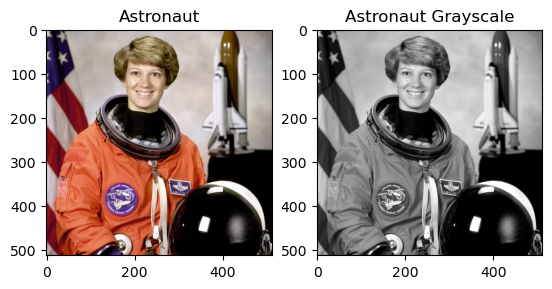

In [2]:
image_rgb = astronaut()
image= cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

plt.subplot(121)
plt.imshow(image_rgb)
plt.title("Astronaut");

plt.subplot(122)
plt.imshow(image, cmap='gray')
plt.title("Astronaut Grayscale");

#### Next we will randomly sample a percentage of pixels in the image to simulate a degraded image. The portion of pixels to randonly sample is denoted by $\alpha$.

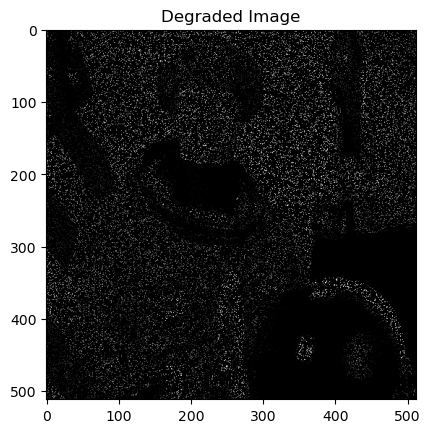

In [3]:
alpha = 0.1 # probability of selecting a pixel
rng = np.random.default_rng()
mask = rng.choice([0,1], size=image.shape, p=[1 - alpha, alpha])

degraded_image = image.copy()
degraded_image[mask == 0] = 0

plt.imshow(degraded_image, cmap='gray')
plt.title("Degraded Image");

### Now let's implement Normalized Convolution to restore this image

First we will see how a regular convolution works for this task

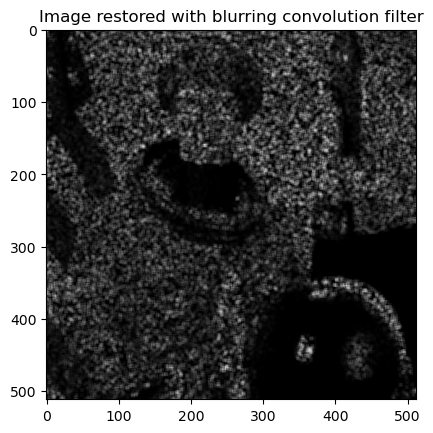

In [4]:
# Apply blurring kernel
kernel = np.ones((5, 5), np.float32) / 25
restore_conv = cv2.filter2D(src=degraded_image, ddepth=-1, kernel=kernel)

plt.imshow(restore_conv, cmap='gray')
plt.title("Image restored with blurring convolution filter");

### Now let's implement Normalized Convolution

In [5]:
f = degraded_image.copy() # signal
c = mask.copy() # certainty
n = 5 # neighborhood size

# pixel applicability
# a = np.array([
#     [1, 2, 1],
#     [1, 4, 1],
#     [1, 2, 1]
# ]).reshape(-1)

a = np.array([
    [1, 1, 2, 1, 1],
    [1, 2, 4, 2, 1],
    [2, 4, 7, 4, 2],
    [1, 2, 4, 2, 1],
    [1, 1, 2, 1, 1]
]).reshape(-1)




# basis functions
# Use the following Polynomial Basis: {1, x, y, x2, xy, y2}
# b = np.array([
#     [-1, 0, 1],
#     [-1, 0, 1],
#     [-1, 0, 1]
# ])

b = np.array([
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2]
])

b.T.reshape(-1)

# split Basis Functions between x and y dimensions
# x dimension (set y=1)
bx = np.vstack((
    np.ones((n**2)),    # 1
    b.T.reshape(-1),    # x
    np.ones((n**2)),    # y
    b.T.reshape(-1)**2, # x^2
    b.T.reshape(-1),    # xy
    np.ones((n**2)),    # y^2
)).T

# y dimension (set x=1)
by = np.vstack((
    np.ones((n**2)),  # 1
    np.ones((n**2)),  # x
    b.reshape(-1),    # y
    np.ones((n**2)),  # x^2
    b.reshape(-1),    # xy
    b.reshape(-1)**2, # y^2
)).T


In [ ]:
by

In [6]:
import scipy 

# Pre-calculate product of certainty and signal
cf = c * f

# G and v are used to calculate "r" from the paper: v = G*r
# r is the parametrization of the 2nd order polynomial for f
G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
v = np.empty(list(f.shape) + [bx.shape[-1]])

# Apply separable cross-correlations

# Pre-calculate quantities recommended in paper
ab = np.einsum("i,ij->ij", a, bx)
abb = np.einsum("ij,ik->ijk", ab, bx)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(
            c, abb[..., i, j], axis=0, mode="constant", cval=0
        )

    v[..., i] = scipy.ndimage.correlate1d(
        cf, ab[..., i], axis=0, mode="constant", cval=0
    )

In [7]:
# Pre-calculate quantities recommended in paper
ab = np.einsum("i,ij->ij", a, by)
abb = np.einsum("ij,ik->ijk", ab, by)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(
            G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
        )

    v[..., i] = scipy.ndimage.correlate1d(
        v[..., i], ab[..., i], axis=1, mode="constant", cval=0
    )

# if G is singular, then we will need to reduce the singularity 
# by adding a perturbation to reduce singularity of G
_p = np.random.normal(loc=0, scale=0.001, size=G.shape)

# Solve r for each pixel
r = np.linalg.solve(G, v)

# Quadratic term
A = np.empty(list(f.shape) + [2, 2])
A[..., 0, 0] = r[..., 3]
A[..., 0, 1] = r[..., 5] / 2
A[..., 1, 0] = A[..., 0, 1]
A[..., 1, 1] = r[..., 4]

In [14]:
ab.shape

(25, 6)

In [9]:
fx = np.zeros_like(f).astype(np.float64)
fy = np.zeros_like(f).astype(np.float64)

for i in range(bx.shape[1]):
    fx += scipy.ndimage.correlate1d(
                r[..., i], np.float64(bx[:, i]), axis=0, mode="constant", cval=0
            )

# axis = 0 for y axis?
for i in range(by.shape[1]):
    fy += scipy.ndimage.correlate1d(
                r[..., i], by[:, i], axis=1, mode="constant", cval=0
            )

In [11]:
fx

array([[1582.42700642, 1249.14086425, 1121.35433412, ..., 1564.86194829,
        1568.70217866, 1577.67490251],
       [1717.09798374, 1334.02363944, 1156.45877182, ..., 1685.93769795,
        1686.85503079, 1696.38638711],
       [1850.77038901, 1469.55419027, 1214.32020113, ..., 1807.5674171 ,
        1807.98559643, 1816.7388538 ],
       ...,
       [2109.7853883 , 2037.9235937 , 2189.20667473, ...,  796.5909666 ,
         506.87883666,  199.55094084],
       [2020.04501908, 1969.14115578, 2088.2198725 , ...,  818.24454718,
         492.00455741,  208.93759843],
       [1898.01834407, 1890.95641886, 1970.3102185 , ...,  844.57658365,
         502.66525728,  267.15743242]])

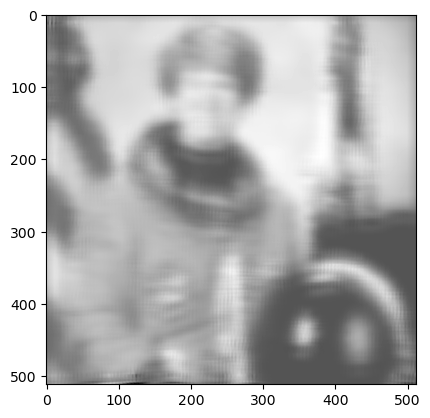

In [10]:
tmp = cv2.normalize(fx + fy, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(tmp, cmap='gray')

In [131]:
tmp

array([[0.66851735, 0.668694  , 0.6685057 , ..., 0.6688195 , 0.6684515 ,
        0.6684301 ],
       [0.6685376 , 0.6687157 , 0.6685249 , ..., 0.6684882 , 0.66846466,
        0.6684516 ],
       [0.6685608 , 0.6688454 , 0.6685512 , ..., 0.6684889 , 0.66849107,
        0.66946316],
       ...,
       [0.6685735 , 0.6684106 , 0.6685771 , ..., 0.6683932 , 0.6684376 ,
        0.6684039 ],
       [0.6685648 , 0.66835016, 0.6684783 , ..., 0.66840667, 0.66839904,
        0.66861856],
       [0.66849726, 0.66830146, 0.66848856, ..., 0.6684032 , 0.6684237 ,
        0.6686419 ]], dtype=float32)

In [132]:
tmp = scipy.ndimage.correlate1d(
                r[..., i], np.float64(bx[:, i]), axis=0, mode="constant", cval=0
            )

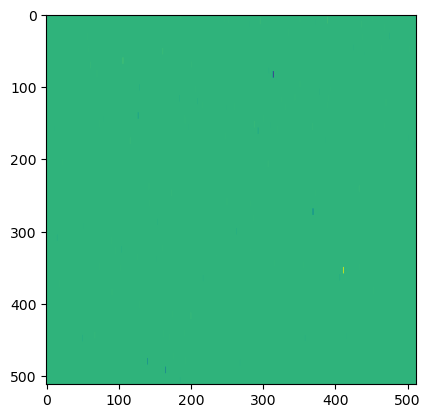

In [133]:
plt.imshow(tmp)

In [40]:
# Basis Functions
# {1, x, y, x2, xy, y2}
# B = np.ones((n*n, 6))

B = np.array([
    [1, -1, -1, 1,  1, 1],
    [1, -1,  0, 1,  0, 0],
    [1, -1,  1, 1, -1, 1],
    [1,  0, -1, 0,  0, 1],
    [1,  0,  0, 0,  0, 0],
    [1,  0,  1, 0,  0, 1],
    [1,  1, -1, 1, -1, 1],
    [1,  1,  0, 1,  0, 0],
    [1,  1,  1, 1,  1, 1]
])

In [9]:
Wa.shape

(9, 9)

In [10]:
B.shape

(9, 6)

$ r = (B^* W_a W_c B)^{-1} B^* W_a W_c f $

In [11]:
np.linalg.inv(B.T @ Wa @ B).shape

(6, 6)

In [12]:
val = np.linalg.inv(B.T @ Wa @ B) @ (B.T @ Wa)
val.shape

(6, 9)

array([[ 1,  2,  1,  1,  4,  1,  1,  2,  1],
       [-1, -2, -1,  0,  0,  0,  1,  2,  1],
       [-1,  0,  1, -1,  0,  1, -1,  0,  1],
       [ 1,  2,  1,  0,  0,  0,  1,  2,  1],
       [ 1,  0, -1,  0,  0,  0, -1,  0,  1],
       [ 1,  0,  1,  1,  0,  1,  1,  0,  1]])

In [130]:
sigma = 4.0

n = int(4 * sigma + 1)
x = np.arange(-n, n + 1, dtype=int)
a = np.exp(-(x**2) / (2 * sigma**2)) 

In [131]:
n

17

In [132]:
x

array([-17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
        -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  12,  13,  14,  15,  16,  17])

In [135]:
a

array([1.19612884e-04, 3.35462628e-04, 8.83826307e-04, 2.18749112e-03,
       5.08606923e-03, 1.11089965e-02, 2.27941809e-02, 4.39369336e-02,
       7.95595087e-02, 1.35335283e-01, 2.16265167e-01, 3.24652467e-01,
       4.57833362e-01, 6.06530660e-01, 7.54839602e-01, 8.82496903e-01,
       9.69233234e-01, 1.00000000e+00, 9.69233234e-01, 8.82496903e-01,
       7.54839602e-01, 6.06530660e-01, 4.57833362e-01, 3.24652467e-01,
       2.16265167e-01, 1.35335283e-01, 7.95595087e-02, 4.39369336e-02,
       2.27941809e-02, 1.11089965e-02, 5.08606923e-03, 2.18749112e-03,
       8.83826307e-04, 3.35462628e-04, 1.19612884e-04])

In [53]:
sigma=3
n = int(4 * sigma + 1)
x = np.arange(-n, n + 1, dtype=np.int64)
a = np.exp(-(x**2) / (2 * sigma**2))
a

array([8.36483472e-05, 3.35462628e-04, 1.20385999e-03, 3.86592014e-03,
       1.11089965e-02, 2.85655008e-02, 6.57285286e-02, 1.35335283e-01,
       2.49352209e-01, 4.11112291e-01, 6.06530660e-01, 8.00737403e-01,
       9.45959469e-01, 1.00000000e+00, 9.45959469e-01, 8.00737403e-01,
       6.06530660e-01, 4.11112291e-01, 2.49352209e-01, 1.35335283e-01,
       6.57285286e-02, 2.85655008e-02, 1.11089965e-02, 3.86592014e-03,
       1.20385999e-03, 3.35462628e-04, 8.36483472e-05])

In [319]:
import scipy


sigma = 3


# Calculate applicability kernel (1D because it is separable)
n = int(4 * sigma + 1)
x = np.arange(-n, n + 1, dtype=np.int64)
a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]

# b: calculate b from the paper. Calculate separately for X and Y dimensions
# [n, 6]
# something looks wrong with the basis functions bx and by
bx = np.stack(
    [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
)
by = np.stack(
    [
        np.ones(a.shape),
        np.ones(a.shape),
        x,
        np.ones(a.shape),
        x**2,
        x,
    ],
    axis=-1,
)

# Pre-calculate product of certainty and signal
cf = c * f

# G and v are used to calculate "r" from the paper: v = G*r
# r is the parametrization of the 2nd order polynomial for f
G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
v = np.empty(list(f.shape) + [bx.shape[-1]])

# Apply separable cross-correlations

# Pre-calculate quantities recommended in paper
ab = np.einsum("i,ij->ij", a, bx)
abb = np.einsum("ij,ik->ijk", ab, bx)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(
            c, abb[..., i, j], axis=0, mode="constant", cval=0
        )

    v[..., i] = scipy.ndimage.correlate1d(
        cf, ab[..., i], axis=0, mode="constant", cval=0
    )

# Pre-calculate quantities recommended in paper
ab = np.einsum("i,ij->ij", a, by)
abb = np.einsum("ij,ik->ijk", ab, by)

# Calculate G and v for each pixel with cross-correlation
for i in range(bx.shape[-1]):
    for j in range(bx.shape[-1]):
        G[..., i, j] = scipy.ndimage.correlate1d(
            G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
        )

    v[..., i] = scipy.ndimage.correlate1d(
        v[..., i], ab[..., i], axis=1, mode="constant", cval=0
    )

# Solve r for each pixel
r = np.linalg.solve(G, v)

# Quadratic term
A = np.empty(list(f.shape) + [2, 2])
A[..., 0, 0] = r[..., 3]
A[..., 0, 1] = r[..., 5] / 2
A[..., 1, 0] = A[..., 0, 1]
A[..., 1, 1] = r[..., 4]

# Linear term
B = np.empty(list(f.shape) + [2])
B[..., 0] = r[..., 1]
B[..., 1] = r[..., 2]

# constant term
C = r[..., 0]

In [321]:
n//2

6

In [314]:
bx.shape

(27, 6)

In [324]:
sigma = 3


# Calculate applicability kernel (1D because it is separable)
n = int(4 * sigma + 1)
x = np.arange(-n//2, n//2 + 1, dtype=np.int64)
a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]

# b: calculate b from the paper. Calculate separately for X and Y dimensions
# [n, 6]
# something looks wrong with the basis functions bx and by
bx = np.stack(
    [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
)
by = np.stack(
    [
        np.ones(a.shape),
        np.ones(a.shape),
        x,
        np.ones(a.shape),
        x**2,
        x,
    ],
    axis=-1,
)

In [325]:
bx.shape

(14, 6)

In [326]:
bx

array([[ 1., -7.,  1., 49.,  1., -7.],
       [ 1., -6.,  1., 36.,  1., -6.],
       [ 1., -5.,  1., 25.,  1., -5.],
       [ 1., -4.,  1., 16.,  1., -4.],
       [ 1., -3.,  1.,  9.,  1., -3.],
       [ 1., -2.,  1.,  4.,  1., -2.],
       [ 1., -1.,  1.,  1.,  1., -1.],
       [ 1.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  1.,  4.,  1.,  2.],
       [ 1.,  3.,  1.,  9.,  1.,  3.],
       [ 1.,  4.,  1., 16.,  1.,  4.],
       [ 1.,  5.,  1., 25.,  1.,  5.],
       [ 1.,  6.,  1., 36.,  1.,  6.]])

In [327]:
bx * by

array([[ 1., -7., -7., 49., 49., 49.],
       [ 1., -6., -6., 36., 36., 36.],
       [ 1., -5., -5., 25., 25., 25.],
       [ 1., -4., -4., 16., 16., 16.],
       [ 1., -3., -3.,  9.,  9.,  9.],
       [ 1., -2., -2.,  4.,  4.,  4.],
       [ 1., -1., -1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  2.,  4.,  4.,  4.],
       [ 1.,  3.,  3.,  9.,  9.,  9.],
       [ 1.,  4.,  4., 16., 16., 16.],
       [ 1.,  5.,  5., 25., 25., 25.],
       [ 1.,  6.,  6., 36., 36., 36.]])

In [177]:
G.shape

(512, 512, 6, 6)

In [178]:
v.shape

(512, 512, 6)

In [168]:
A.shape

(512, 512, 2, 2)

In [169]:
B.shape

(512, 512, 2)

In [170]:
C.shape

(512, 512)

In [172]:
r.shape

(512, 512, 6)

In [174]:
bx.shape

(35, 6)

In [175]:
by.shape

(35, 6)

### Reconstruct the signal with
$ \hat{f} = Br $

In [183]:
fx = bx @ np.c_[r[1, 1, :]] 
fy = by @ np.c_[r[1, 1, :]] 

In [184]:
fx.shape

(35, 1)

In [185]:
fy.shape

(35, 1)

In [186]:
n

17

In [193]:
bx.shape

(35, 6)

In [237]:
fx = np.zeros_like(f).astype(np.float64)
fy = np.zeros_like(f).astype(np.float64)

for i in range(bx.shape[1]):
    fx += scipy.ndimage.correlate1d(
                r[..., i], np.float64(bx[:, i]), axis=0, mode="constant", cval=0
            )

# axis = 0 for y axis?
for i in range(by.shape[1]):
    fy += scipy.ndimage.correlate1d(
                r[..., i], by[:, i], axis=1, mode="constant", cval=0
            )

In [225]:
np.float64(bx[:, i]).dtype

dtype('float64')

In [226]:
r[..., i].dtype

dtype('float64')

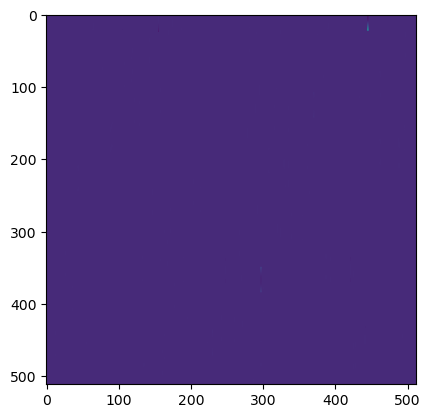

In [235]:
fx_norm = cv2.normalize(fx, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(fx_norm*1000)

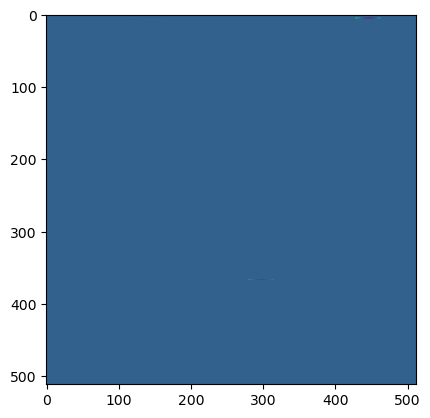

In [238]:
fy_norm = cv2.normalize(fy, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(fy_norm*1000)

In [278]:
bx.shape

(35, 6)

In [276]:
r.shape

(512, 512, 6)

In [286]:
# tmp = np.einsum("ij,ik->ijk", r, bx)

tmp = np.einsum("mnk,kj->mn", r, bx.T)

In [293]:
np.c_[r[0, 0, :]].shape

(6, 1)

In [303]:
bx

array([[  1., -17.,   1., 289.,   1., -17.],
       [  1., -16.,   1., 256.,   1., -16.],
       [  1., -15.,   1., 225.,   1., -15.],
       [  1., -14.,   1., 196.,   1., -14.],
       [  1., -13.,   1., 169.,   1., -13.],
       [  1., -12.,   1., 144.,   1., -12.],
       [  1., -11.,   1., 121.,   1., -11.],
       [  1., -10.,   1., 100.,   1., -10.],
       [  1.,  -9.,   1.,  81.,   1.,  -9.],
       [  1.,  -8.,   1.,  64.,   1.,  -8.],
       [  1.,  -7.,   1.,  49.,   1.,  -7.],
       [  1.,  -6.,   1.,  36.,   1.,  -6.],
       [  1.,  -5.,   1.,  25.,   1.,  -5.],
       [  1.,  -4.,   1.,  16.,   1.,  -4.],
       [  1.,  -3.,   1.,   9.,   1.,  -3.],
       [  1.,  -2.,   1.,   4.,   1.,  -2.],
       [  1.,  -1.,   1.,   1.,   1.,  -1.],
       [  1.,   0.,   1.,   0.,   1.,   0.],
       [  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   1.,   4.,   1.,   2.],
       [  1.,   3.,   1.,   9.,   1.,   3.],
       [  1.,   4.,   1.,  16.,   1.,   4.],
       [  

In [302]:
bx @ np.c_[r[100, 100, :]]

array([[5076.54726028],
       [4406.34037447],
       [3776.71471991],
       [3187.67029658],
       [2639.2071045 ],
       [2131.32514366],
       [1664.02441407],
       [1237.30491572],
       [ 851.16664861],
       [ 505.60961274],
       [ 200.63380811],
       [ -63.76076527],
       [-287.5741074 ],
       [-470.8062183 ],
       [-613.45709795],
       [-715.52674636],
       [-777.01516353],
       [-797.92234945],
       [-778.24830414],
       [-717.99302757],
       [-617.15651977],
       [-475.73878072],
       [-293.73981043],
       [ -71.1596089 ],
       [ 192.00182388],
       [ 495.7444879 ],
       [ 840.06838316],
       [1224.97350966],
       [1650.45986741],
       [2116.5274564 ],
       [2623.17627663],
       [3170.40632811],
       [3758.21761083],
       [4386.61012479],
       [5055.58386999]])

In [287]:
tmp.shape

(512, 512)

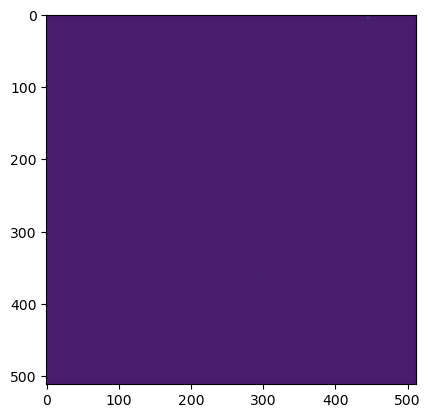

In [289]:
tmp = cv2.normalize(tmp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


plt.imshow(tmp)

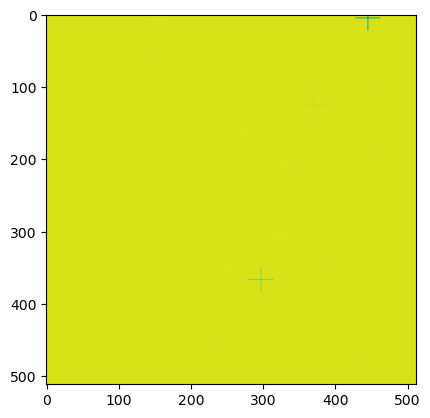

In [274]:
tmp = scipy.ndimage.correlate1d(
                r[..., 0], np.float64(bx[:, 0]), axis=0, mode="constant", cval=0
            ) \
        + scipy.ndimage.correlate1d(
                r[..., 0], np.float64(by[:, 0]), axis=1, mode="constant", cval=0
            )

tmp = cv2.normalize(tmp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


plt.imshow(tmp)

In [ ]:
tmp = np.einsum('', '', )

In [275]:
tmp

array([[0.9385758 , 0.9386102 , 0.93862534, ..., 0.93858564, 0.9385894 ,
        0.9385981 ],
       [0.9385771 , 0.93861175, 0.93862677, ..., 0.93856907, 0.9385723 ,
        0.93860805],
       [0.93862516, 0.9386591 , 0.9386738 , ..., 0.93860507, 0.9386004 ,
        0.9386024 ],
       ...,
       [0.93858016, 0.9385738 , 0.93863505, ..., 0.93858504, 0.9385709 ,
        0.93857294],
       [0.93858176, 0.9385757 , 0.93863755, ..., 0.9385808 , 0.9385667 ,
        0.9385688 ],
       [0.9386256 , 0.9386179 , 0.93868077, ..., 0.9385836 , 0.93856716,
        0.9385688 ]], dtype=float32)